In [ ]:
import sys
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
import joblib
import os
import scipy.io as sio


In [2]:
# Adjust the path to your project root directory where 'models' folder is located
project_root = os.path.abspath('../../../')  # or the relative path to your root from the notebook folder

if project_root not in sys.path:
    sys.path.insert(0, project_root)

from src.models.pca import PCA_AE
from src.models.mlp import MLP_AE
from src.models.cnn import CNN_AE

from src.utils import *

In [3]:
project = 'fvcom'

In [14]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
os.makedirs(f'{project_root}/src/models/checkpoints/{project}', exist_ok=True)

load_existing_models = True
latent_dim = 75

In [15]:
grid_x = np.load(f'{project_root}/data/{project}/grid_x.npy')
grid_y = np.load(f'{project_root}/data/{project}/grid_y.npy')
grid_x_m, grid_y_m = sp_proj('forward', grid_x, grid_y,  'm')

u1 = np.load(f'{project_root}/data/{project}/u_interp.npy') 
u2 = np.load(f'{project_root}/data/{project}/v_interp.npy')
nt, n1, n2 = u1.shape
mask = ~np.isnan(u1[0,:,:])

X, scaler = transform_data_for_AE(u1,u2)
data = transform_data_for_AE_inverse(X, scaler)
data[:, :, ~mask] = np.nan 

In [16]:
# === Consistent train/val/test split ===
n_train = int(0.5 * nt)
n_val = int(0.2 * nt)
n_test = nt - n_train - n_val

train_idx = np.arange(0, n_train)
val_idx = np.arange(n_train, n_train + n_val)
test_idx = np.arange(n_train + n_val, nt)


X_train = X[train_idx]
X_val = X[val_idx]
X_test = X[test_idx]

print(f"Train shape: {X_train.shape}, Val shape: {X_val.shape}, Test shape: {X_test.shape}")


Train shape: (7737, 2, 64, 64), Val shape: (3095, 2, 64, 64), Test shape: (4643, 2, 64, 64)


In [17]:
mlp_input_dim = X[:, :, mask].reshape(X.shape[0], -1).shape[1]

In [18]:
pca = PCA_AE.load(f'{project_root}/src/models/checkpoints/{project}/pca_{latent_dim}_model.pkl')
mlp = MLP_AE(input_dim=mlp_input_dim, latent_dim=latent_dim, mask=mask)
mlp.load_state_dict(torch.load(f'{project_root}/src/models/checkpoints/{project}/mlp_{latent_dim}_model.pth'))
mlp.to(device)
cnn = CNN_AE(latent_dim=latent_dim)
cnn.load_state_dict(torch.load(f'{project_root}/src/models/checkpoints/{project}/cnn_{latent_dim}_model.pth'))
cnn.to(device);

In [19]:
# Compute test error for each model
mask_broadcast = mask[None, :, :]  # shape (1, n1, n2)

# 1. PCA only (reconstruction from PCA)
X_pca_recon, Z_pca = pca.forward(X)
X_pca_recon = transform_data_for_AE_inverse(X_pca_recon, scaler)

# 2. MLP Autoencoder
mlp.eval()
with torch.no_grad():
    X_mlp_recon, Z_mlp = mlp(torch.tensor(X, dtype=torch.float32, device=device))
    X_mlp_recon = X_mlp_recon.cpu().numpy()
    X_mlp_recon = transform_data_for_AE_inverse(X_mlp_recon, scaler)

# 3. CNN Autoencoder (batched to avoid CUDA OOM)
cnn.eval()
batch_size = 16  
n_samples = X.shape[0]
X_cnn_recon = []
with torch.no_grad():
    for i in range(0, n_samples, batch_size):
        batch = X[i:i+batch_size]
        batch_tensor = torch.tensor(batch, dtype=torch.float32, device=device)
        recon_batch, _ = cnn(batch_tensor)
        X_cnn_recon.append(recon_batch.cpu().numpy())
X_cnn_recon = np.concatenate(X_cnn_recon, axis=0)
X_cnn_recon = transform_data_for_AE_inverse(X_cnn_recon, scaler)
X_cnn_recon[:,:, ~mask] = np.nan  

In [20]:
def compute_rmse(true, pred):    
    return np.sqrt(np.nanmean((true - pred) ** 2))

fields = {
    'Truth': (data[:, 0], data[:, 1]),
    'PCA': (X_pca_recon[:, 0], X_pca_recon[:, 1]),
    'MLP': (X_mlp_recon[:, 0], X_mlp_recon[:, 1]),
    'CNN': (X_cnn_recon[:, 0], X_cnn_recon[:, 1]),
}

u_true, v_true = fields['Truth']
omega_true = vort_FVCOM(u_true, v_true, grid_x_m, grid_y_m)
psi_true = streamfunction_FVCOM(omega_true, grid_x_m, grid_y_m)
omega_true[..., ~mask] = np.nan
psi_true[..., ~mask] = np.nan

omega_fields = {'Truth': omega_true,}
psi_fields = {'Truth': psi_true,}

results = {}

for key, (u, v) in fields.items():
    u_pred, v_pred = u, v

    omega_field = vort_FVCOM(u, v, grid_x_m, grid_y_m)
    psi_field = streamfunction_FVCOM(omega_field, grid_x_m, grid_y_m)
    omega_field[..., ~mask] = np.nan
    psi_field[..., ~mask] = np.nan

    omega_fields[key] = omega_field
    psi_fields[key] = psi_field

    # Split indices
    splits = {
        'total': np.arange(u_true.shape[0]),
        'train': train_idx,
        'val': val_idx,
        'test': test_idx
    }

    # Compute RMSE for each split
    rmse = {}
    for split_name, idx in splits.items():
        rmse_u = compute_rmse(u_true[idx], u_pred[idx])
        rmse_v = compute_rmse(v_true[idx], v_pred[idx])
        rmse_omega = compute_rmse(omega_true[idx], omega_field[idx])
        rmse_psi = compute_rmse(psi_true[idx], psi_field[idx])
        rmse[split_name] = {
            'u': rmse_u,
            'v': rmse_v,
            'omega': rmse_omega,
            'psi': rmse_psi
        }

    results[key] = {'rmse': rmse}
    

In [21]:
# Print results
for key in ['PCA', 'MLP', 'CNN']:
    print(f"{key}:")
    for split_name, rmse in results[key]['rmse'].items():
        print(f"  {split_name}: u={rmse['u']:.4f}, v={rmse['v']:.4f}, omega={1000*rmse['omega']:.4f}, psi={rmse['psi']:.4f}")

PCA:
  total: u=0.0398, v=0.0419, omega=0.0151, psi=312.4701
  train: u=0.0386, v=0.0407, omega=0.0146, psi=304.0110
  val: u=0.0406, v=0.0426, omega=0.0151, psi=322.2597
  test: u=0.0412, v=0.0433, omega=0.0159, psi=319.6645
MLP:
  total: u=0.0437, v=0.0445, omega=0.0161, psi=771.7592
  train: u=0.0405, v=0.0413, omega=0.0151, psi=671.8654
  val: u=0.0467, v=0.0477, omega=0.0166, psi=865.5398
  test: u=0.0466, v=0.0473, omega=0.0173, psi=856.4847
CNN:
  total: u=0.0401, v=0.0407, omega=0.0155, psi=353.1317
  train: u=0.0366, v=0.0373, omega=0.0144, psi=266.4485
  val: u=0.0427, v=0.0434, omega=0.0161, psi=419.6408
  test: u=0.0435, v=0.0441, omega=0.0170, psi=424.1910


In [22]:
# Compute average error between prediction and ground truth for u and v over the test set
average_rmse = np.nanmean(np.abs(X_test - X_cnn_recon[test_idx]))
rmse_per_timestep = np.nanmean(np.abs(X[test_idx] - X_cnn_recon[test_idx]), axis=(1,2,3))

indices_avg_error = np.argsort(np.abs(rmse_per_timestep - average_rmse))[:20]
print("Indices with average error close to mean error (CNN):", test_idx[indices_avg_error])

# Compute average error between prediction and ground truth for u and v over the test set
average_rmse = np.nanmean(np.abs(X_test - X_pca_recon[test_idx]))
rmse_per_timestep = np.nanmean(np.abs(X[test_idx] - X_pca_recon[test_idx]), axis=(1,2,3))

indices_avg_error = np.argsort(np.abs(rmse_per_timestep - average_rmse))[:20]
print("Indices with average error close to mean error (PCA):", test_idx[indices_avg_error])

Indices with average error close to mean error (CNN): [11370 14883 13560 13016 14619 12385 12671 12386 14114 11429 14695 15422
 10912 11792 14752 14645 11137 13658 12055 11590]
Indices with average error close to mean error (PCA): [14114 11153 14645 14752 13072 10912 11260 14837 11792 13070 13285 13292
 15074 13450 11590 13871 12671 13560 11334 11095]


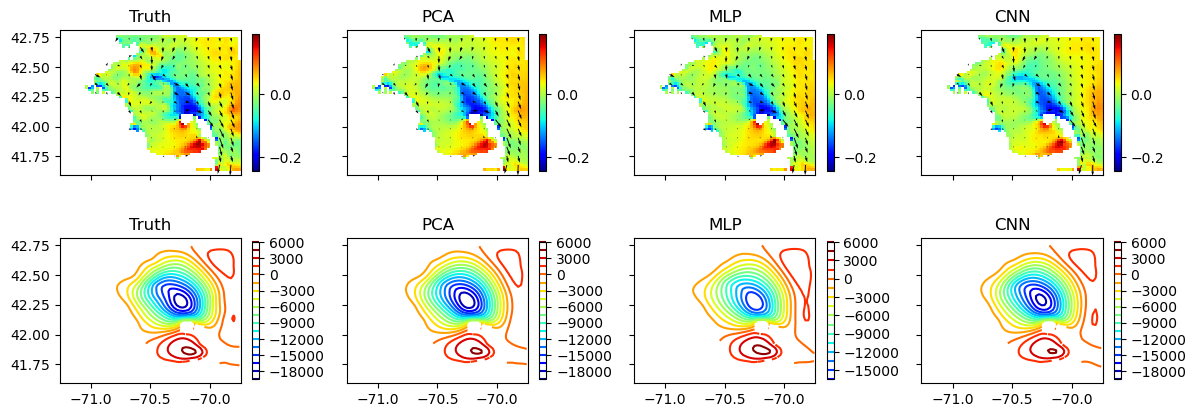

In [23]:
# Choose a timestep to visualize
timestep = 12120


# Helper for contour plots with shared vmin/vmax for all subplots
def plot_contours(data_dict, title, grid_x, grid_y, row_idx=0):
    arrs = [np.array(arr[timestep]) for arr in data_dict.values()]
    vmin = min(np.nanmin(arr) for arr in arrs)
    vmax = max(np.nanmax(arr) for arr in arrs)
    for i, (key, arr) in enumerate(data_dict.items()):
        if title == '$\omega$':
            cf = axs[row_idx, i].pcolormesh(grid_x, grid_y, 1000*arr[timestep], vmin=1000*vmin, vmax=1000*vmax, cmap='jet')
        elif title == '$\psi$':
            cf = axs[row_idx, i].contour(grid_x, grid_y, arr[timestep], levels=20, vmin=vmin, vmax=vmax, cmap='jet')
        axs[row_idx, i].set_title(key)
        axs[row_idx, i].set_aspect('equal')
        plt.colorbar(cf, ax=axs[row_idx, i], orientation='vertical', shrink=0.7)

fig, axs = plt.subplots(2, 4, figsize=(12, 4.5), sharex=True, sharey=True)
plot_contours(omega_fields, '$\omega$', grid_x, grid_y, row_idx=0)

step = 4
xq, yq, mask_q = grid_x[::step, ::step], grid_y[::step, ::step], mask[::step, ::step]
for i, (key, (u, v)) in enumerate(fields.items()):
    axs[0, i].quiver(xq[mask_q], yq[mask_q], u[timestep, ::step, ::step][mask_q], v[timestep, ::step, ::step][mask_q], scale=7, scale_units='xy')
    axs[0, i].set_title(key)
    axs[0, i].set_aspect('equal')

plot_contours(psi_fields, '$\psi$', grid_x, grid_y, row_idx=1)

plt.tight_layout()
